In [1]:
import poppy
import numpy as np
import matplotlib.pyplot as plt
import polutils as pol
import matplotlib

# inspired by http://nipunbatra.github.io/2014/08/latexify/
# params = {
#     'text.latex.preamble': ['\\usepackage{gensymb}'],
#     'image.origin': 'lower',
#     'image.interpolation': 'nearest',
#     'image.cmap': 'gray',
#     'axes.grid': False,
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
#     'axes.labelsize': 8, # fontsize for x and y labels (was 10)
#     'axes.titlesize': 8,
#     'font.size': 8, # was 10
#     'legend.fontsize': 6, # was 10
#     'xtick.labelsize': 8,
#     'ytick.labelsize': 8,
#     'text.usetex': True,
#     'figure.figsize': [3.39, 2.10],
#     'font.family': 'serif',
# }
# matplotlib.rcParams.update(params)

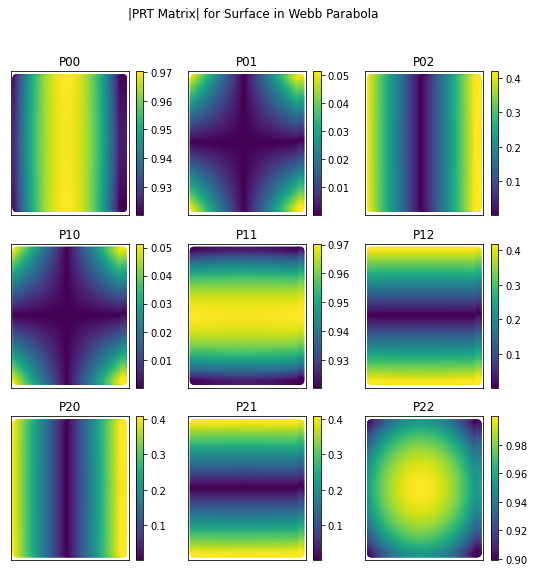

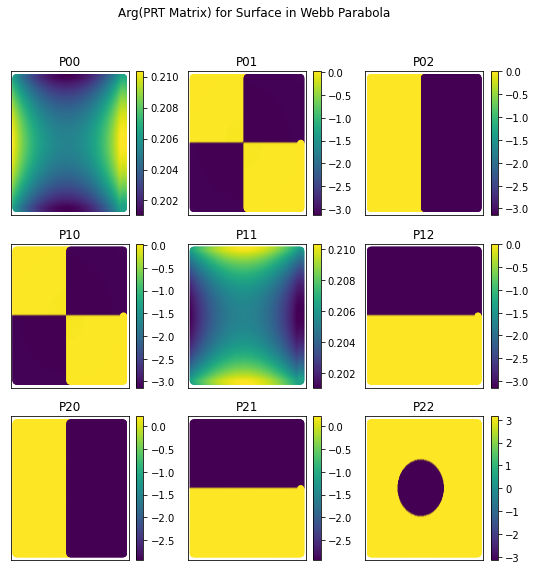

In [2]:
# Going to need to do 3 propagations (Ex Ey Ez) and make 9 optical elements
# Here x y z refer to the global coordinates of the system
# The Efield is still orthogonal to the axis of propagation, the propagation direction just changes

# Step 1) Generate PRT Matrix

# Test the PRT Computation
n1 = 1.4358 + 1j*9.4953 # Aluminum at 1um
n2 = 1 # vaccum
npix = 256

# a 6.5m Parabola 
pth = '/Users/jashcraft/Desktop/prt-data/Webb_Parabola_ray_data.txt'

# Compute PRT information
aoi,x,y,kin,kout,norm = pol.ConvertBatchRayData(pth,n1,n2,mode='reflection')
ts,tp = pol.FresnelCoefficients(aoi,n1,n2)
Pmat = np.zeros([3,3,kin.shape[1]],dtype='complex128')
Jmat = np.zeros([3,3,kin.shape[1]],dtype='complex128')

for i in range(kin.shape[1]):

    Pmat[:,:,i],Jmat[:,:,i] = pol.ConstructPRTMatrix(
        kin[:,i],
        kout[:,i],
        norm[:,i],
        aoi[i],
        n1,
        n2,
        mode='reflection')
    
# Plot PRT Matrix
fig,axs = plt.subplots(figsize=[9,9],nrows=3,ncols=3)
plt.suptitle('|PRT Matrix| for Surface in Webb Parabola')
for j in range(3):
    for k in range(3):
        ax = axs[j,k]
        ax.set_title('P{j}{k}'.format(j=j,k=k))
        sca = ax.scatter(x,y,c=np.abs(Pmat[j,k,:]))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.colorbar(sca,ax=ax)
plt.show()

fig,axs = plt.subplots(figsize=[9,9],nrows=3,ncols=3)
plt.suptitle('Arg(PRT Matrix) for Surface in Webb Parabola')
for j in range(3):
    for k in range(3):
        ax = axs[j,k]
        ax.set_title('P{j}{k}'.format(j=j,k=k))
        sca = ax.scatter(x,y,c=np.angle(Pmat[j,k,:]))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.colorbar(sca,ax=ax)
plt.show()


In [3]:
# Arrays for our Complex PRT matrix - need a square grid of rays the size of our wavefront
P00 = np.reshape(Pmat[0,0,:],[npix,npix])
P01 = np.reshape(Pmat[0,1,:],[npix,npix])
P02 = np.reshape(Pmat[0,2,:],[npix,npix])
P10 = np.reshape(Pmat[1,0,:],[npix,npix])
P11 = np.reshape(Pmat[1,1,:],[npix,npix])
P12 = np.reshape(Pmat[1,2,:],[npix,npix])
P20 = np.reshape(Pmat[2,0,:],[npix,npix])
P21 = np.reshape(Pmat[2,1,:],[npix,npix])
P22 = np.reshape(Pmat[2,2,:],[npix,npix])

# Step 2) Interpolate PRT Matrix onto square grid if the rays aren't evenly spaced

# Step 3) Fresnel Propagate
import astropy.units as u
wl = 1e-6
wf_pol = poppy.FresnelWavefront(6.5*u.m,wavelength=wl,npix=npix,oversample=4)
wf_npl = poppy.FresnelWavefront(6.5*u.m,wavelength=wl,npix=npix,oversample=4)
wf_pxy = poppy.FresnelWavefront(6.5*u.m,wavelength=wl,npix=npix,oversample=4)

In [4]:
P00 = poppy.ArrayOpticalElement(transmission=np.abs(P00),
                                opd=wl*np.angle(P00)/(2*np.pi),
                                name='P00',
                                pixelscale=6.5/256*u.m/u.pixel)

P01 = poppy.ArrayOpticalElement(transmission=np.abs(P01),
                                opd=wl*np.angle(P01)/(2*np.pi),
                                name='P01',
                                pixelscale=6.5/256*u.m/u.pixel)

In [6]:
wf_pol *= P00
wf_pxy *= P01
# wf_pol *= 1/np.sqrt(2)
# wf_pxy *= 1/np.sqrt(2)

def ToFocus(wf):
    z = 15880/2*u.m
    wf *= poppy.CircularAperture(radius=6.5/2*u.m)
    wf *= poppy.QuadraticLens(z)
    wf.propagate_fresnel(z)
    return wf
    
psf_pol = ToFocus(wf_pol)
psf_npl = ToFocus(wf_npl)
psf_pxy = ToFocus(wf_pxy)

After resampling, optic phasor shape (128, 128) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
After resampling, optic phasor shape (128, 128) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.


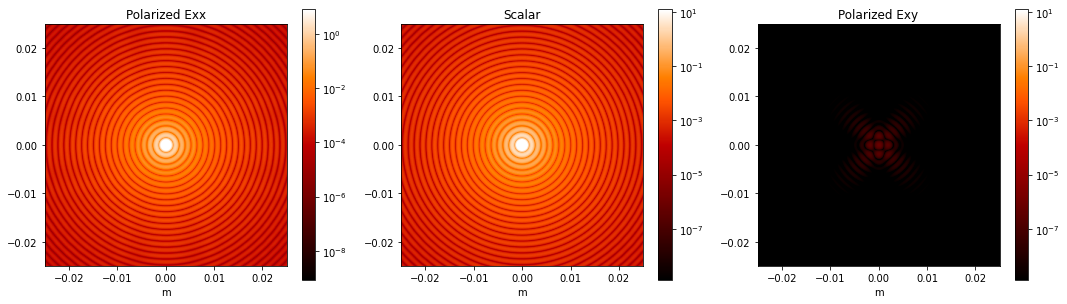

In [7]:
fig, ax = plt.subplots(ncols=3,figsize=[15,5])
im1 = psf_pol.display(colorbar=True, imagecrop=5e-2, scale='log', 
                vmax=psf_pol.amplitude.max(), vmin=psf_pol.amplitude.max()*1e-10,
                title='Polarized Exx',ax=ax[0])
im2 = psf_npl.display(colorbar=True, imagecrop=5e-2, scale='log', 
                vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*1e-10,
                title='Scalar',ax=ax[1])
im3 = psf_pxy.display(colorbar=True,imagecrop=5e-2, scale='log', 
                vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*1e-10,
                title='Polarized Exy',ax=ax[2])
plt.tight_layout(h_pad=1)
plt.show()

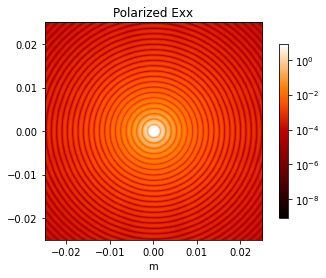

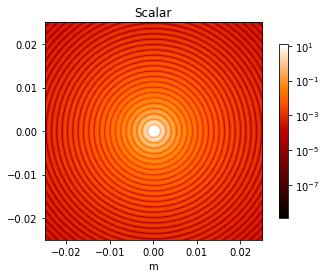

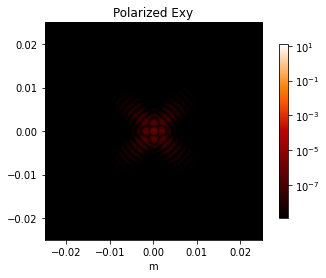

In [8]:
plt.figure()
psf_pol.display(colorbar=True, imagecrop=5e-2, scale='log', 
                vmax=psf_pol.amplitude.max(), vmin=psf_pol.amplitude.max()*1e-10,
                title='Polarized Exx')
plt.show()

plt.figure()
psf_npl.display(colorbar=True, imagecrop=5e-2, scale='log', 
                vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*1e-10,
                title='Scalar')
plt.show()

plt.figure()
psf_pxy.display(colorbar=True, imagecrop=5e-2, scale='log', 
                vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*1e-10,
                title='Polarized Exy')
plt.show()

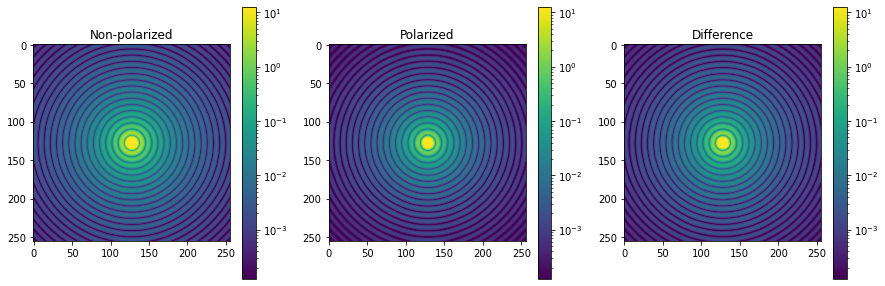

polarized sum =  12711.592962804354
unpolarized sum =  5369.844175593328


In [9]:
from matplotlib.colors import LogNorm

dim = int(psf_pol.wavefront.shape[0]/2)
cut = 128
floor = 1e-5

def ComputeIntensity(wfarray):
    return np.abs(wfarray*np.conj(wfarray))

psf_pol_xx = ComputeIntensity(psf_pol.wavefront)
psf_pol_yx = ComputeIntensity(psf_pxy.wavefront)
wfnpl = ComputeIntensity(psf_npl.wavefront)[dim-cut:dim+cut,dim-cut:dim+cut]
wfpol = (psf_pol_xx + psf_pol_yx)[dim-cut:dim+cut,dim-cut:dim+cut]
wfdif = wfnpl-wfpol

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Non-polarized')
plt.imshow(np.abs(wfnpl),
           norm=LogNorm(vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*floor))
plt.colorbar()
plt.subplot(132)
plt.title('Polarized')
plt.imshow(np.abs(wfpol),
           norm=LogNorm(vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*floor))
plt.colorbar()
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(wfdif),
           norm=LogNorm(vmax=psf_npl.amplitude.max(), vmin=psf_npl.amplitude.max()*floor))
plt.colorbar()
plt.show()

print('polarized sum = ',np.sum(np.abs(wfnpl)))
print('unpolarized sum = ',np.sum(np.abs(wfpol)))

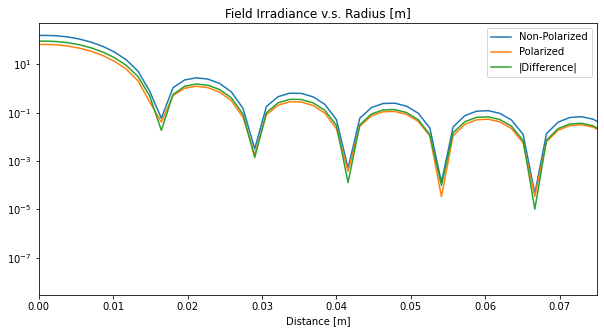

In [10]:
pol_prof = np.abs(wfpol[128,:])#np.abs(psf_pol.wavefront[dim,dim-cut:dim+cut])
npl_prof = np.abs(wfnpl[128,:])#np.abs(psf_npl.wavefront[dim,dim-cut:dim+cut])
dif_prof = np.abs(wfdif[128,:])
x = np.linspace(-.2,0.2,pol_prof.shape[0]) # approximation of actual pixel scale
plt.figure(figsize=[10,5])
plt.title('Field Irradiance v.s. Radius [m]')
plt.plot(x,npl_prof,label='Non-Polarized')
plt.plot(x,pol_prof,label='Polarized')
plt.plot(x,dif_prof,label='|Difference|')
plt.xlim([0,0.075])
plt.yscale('log')
plt.xlabel('Distance [m]')
plt.legend()
plt.show()

In [ ]:
plt.imshow(ComputeIntensity(psf_pxy.wavefront))